## 📊 About the Dataset

### 🧠 What is a Brain Tumor?
A brain tumor is a mass or collection of abnormal cells in the brain. Since the skull is a rigid and enclosed structure, any abnormal growth can increase pressure inside the skull, potentially causing **brain damage** and becoming **life-threatening**. Tumors may be:
- **Benign (non-cancerous)**
- **Malignant (cancerous)**

---

### 🎯 Importance of Brain Tumor Detection
Early detection and classification of brain tumors are **crucial** in medical diagnosis and treatment planning. Proper identification aids in:
- Choosing effective treatments  
- Improving patient outcomes  
- Reducing the risk of permanent damage

---

### 🧪 Deep Learning Approach
This project applies **Convolutional Neural Networks (CNNs)** for:
- Detecting tumors from MRI images  
- Classifying tumors into **4 categories**  
- Identifying tumor **location** through segmentation

Instead of using separate models for each task, a **multi-task CNN** handles detection, classification, and localization together.

---

### 📁 Dataset Overview
This dataset is a combination of **3 sources**:
- **Figshare**
- **SARTAJ**
- **Br35H**

It includes a total of **7023 MRI images** labeled into **4 classes**:

| Class        | Description                 |
|--------------|-----------------------------|
| **Glioma**    | Tumor from glial cells       |
| **Meningioma**| Tumor in meninges            |
| **Pituitary** | Tumor in pituitary gland     |
| **No Tumor**  | Normal brain scan            |

---

### 🔁 4-Class Classification Problem
The goal is to classify each MRI image into one of these **four categories**.

> **Note**: "No tumor" images were sourced from the **Br35H** dataset.  
> The **glioma images from SARTAJ** were replaced due to mislabeling issues.



## 📦 Step 1: Importing all the necessary files

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image

## 📁 Step 2: Loading MRI Images from Folders

We define a custom function `load_data_from_directory()` that:

- Iterates over folders (`glioma`, `meningioma`, `no_tumor`, `pituitary`)
- Loads each image, resizes it to 128x128, and converts it to a NumPy array
- Labels are derived from the folder names


In [3]:
def load_data_from_directory(base_path, image_size=(128, 128)):
    images = []  # hold the image data as NumPy arrays
    labels = []  # hold the corresponding class labels (folder names)

    # Get list of class folders inside the base directory (e.g., glioma, meningioma, etc.)
    class_names = os.listdir(base_path)

    # Iterate over each class folder
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)  # Create full path to the class folder
        
        # Skip if it's not a directory (helps avoid errors from hidden files)
        if not os.path.isdir(class_path):
            continue

        # Iterate through each image file in the class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)  # Full path to the image file
            
            try:
                # Open the image and convert it to RGB format (ensures 3 color channels)
                img = Image.open(img_path).convert('RGB')
                
                # Resize the image to the desired fixed size 128 x 128
                img = img.resize(image_size)
                
                # Convert image to NumPy array and add to the images list
                images.append(np.array(img))
                
                # Append the class label (folder name) to the labels list
                labels.append(class_name)
            
            except Exception as e:
                # If an image fails to load, print the error and continue
                print(f"Error loading image {img_path}: {e}")

    # Convert lists to NumPy arrays for easy handling in training
    return np.array(images), np.array(labels)


## 📂 Step 3: Load Training and Testing Data

We now load the image data and corresponding labels using our custom `load_data_from_directory()` function.

- The function reads all images from the `training/` and `testing/` folders.
- Each image is resized to `(128, 128)` and converted to a NumPy array.
- Labels are automatically assigned based on the folder name (e.g., `glioma`, `no_tumor`, etc.).

This returns:
- `X_train`, `X_test`: arrays of images
- `y_train`, `y_test`: arrays of labels (class names)


In [4]:
X_train, y_train = load_data_from_directory('training')
X_test, y_test = load_data_from_directory('testing')

## 🧹 Step 4: Preprocessing the Data

To prepare the image and label data for training:

1. **Normalize the Images**  
   - We scale all pixel values in `X_train` and `X_test` from the range [0, 255] to [0, 1] by dividing by 255.0.
   - This improves model convergence and stability during training.

2. **Encode the Labels**  
   - The folder names (e.g., `glioma`, `no_tumor`, etc.) are categorical strings.
   - We use `LabelEncoder()` to convert these class names into numeric labels (`0`, `1`, `2`, `3`).

3. **One-Hot Encoding**  
   - Since this is a multi-class classification problem, we one-hot encode the numeric labels using `to_categorical()` to get binary class matrices.
   - For example, label `2` becomes `[0, 0, 1, 0]`.

4. **Check Data Shapes**  
   - Finally, we print the shapes of the training and testing image arrays and the class label mapping to confirm everything is prepared correctly.


In [5]:
from keras.utils import to_categorical

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode labels to numbers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# One-hot encode for classification
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

Training data shape: (5712, 128, 128, 3)
Testing data shape: (1311, 128, 128, 3)
Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 🔀 Step 5: Shuffle the Dataset

Shuffling the data ensures that the training and testing sets are well mixed. This is especially important when images are loaded in a specific folder order (which can unintentionally group similar classes).

- We use `sklearn.utils.shuffle()` to randomly reorder both the image arrays and their corresponding one-hot encoded labels.
- Setting `random_state=42` ensures reproducibility — the same shuffle order will be applied each time the code is run.


In [6]:
from sklearn.utils import shuffle

# Combine and shuffle (just to be safe — especially for custom folder loaders)
X_train, y_train = shuffle(X_train, y_train_cat, random_state=42)
X_test, y_test = shuffle(X_test, y_test_cat, random_state=42)


## 🧠 Step 6: Building the CNN Model

We define a Convolutional Neural Network (CNN) using Keras' `Sequential` API. The model consists of the following layers:

### 🔷 Convolutional Layers
- **Conv2D(32)**: 32 filters of size 3x3 with ReLU activation.
- **Conv2D(64)** and **Conv2D(128)**: Deeper layers with increasing filters to capture more complex features.

### 🔷 MaxPooling Layers
- After each convolution, a `MaxPooling2D(2,2)` layer is applied to reduce the spatial dimensions and computational complexity.

### 🔷 Batch Normalization
- Applied after each pooling layer to stabilize and speed up training.

### 🔷 Fully Connected Layers
- **Flatten()**: Converts the 3D output of conv layers into a 1D vector.
- **Dense(258)**: A dense hidden layer with ReLU activation.
- **Dropout(0.5)**: Helps prevent overfitting by randomly deactivating 50% of neurons during training.

### 🔷 Output Layer
- **Dense(4, activation='softmax')**: Final output layer with 4 units (for 4 classes) and softmax activation to produce class probabilities.


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(258, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])


## 🛠️ Step 7: Compiling the Model

We compile the CNN using the following settings:

- **Optimizer:** `adam`  
  A popular optimizer that adapts the learning rate during training for faster convergence.

- **Loss Function:** `categorical_crossentropy`  
  Used for multi-class classification problems when labels are one-hot encoded.

- **Metrics:** `accuracy`  
  We use accuracy to monitor the performance of the model during training and validation.


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



## 📈 Step 8: Training the Model with Early Stopping

We train the model using the `fit()` function with the following parameters:

- **Epochs:** Set to 20 (maximum number of training cycles)
- **Validation Data:** Uses `X_test` and `y_test` to evaluate performance after each epoch
- **Callbacks:** `EarlyStopping` is used to prevent overfitting

### 🔄 EarlyStopping Explained:
- **monitor='val_loss'**: Watch the validation loss during training
- **patience=3**: Stop training if the validation loss doesn’t improve for 3 consecutive epochs
- **restore_best_weights=True**: After stopping, the model will revert to the weights from the epoch with the best validation loss


In [9]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])



Epoch 1/20


179/179 [==============================] - 113s 614ms/step - loss: 1.3949 - accuracy: 0.7078 - val_loss: 5.5833 - val_accuracy: 0.2563
Epoch 2/20
179/179 [==============================] - 112s 626ms/step - loss: 0.5679 - accuracy: 0.7894 - val_loss: 1.4320 - val_accuracy: 0.5187
Epoch 3/20
179/179 [==============================] - 104s 582ms/step - loss: 0.4620 - accuracy: 0.8262 - val_loss: 0.6864 - val_accuracy: 0.7483
Epoch 4/20
179/179 [==============================] - 98s 550ms/step - loss: 0.4009 - accuracy: 0.8503 - val_loss: 0.3695 - val_accuracy: 0.8467
Epoch 5/20
179/179 [==============================] - 81s 452ms/step - loss: 0.3244 - accuracy: 0.8818 - val_loss: 0.3224 - val_accuracy: 0.8787
Epoch 6/20
179/179 [==============================] - 79s 441ms/step - loss: 0.2918 - accuracy: 0.8922 - val_loss: 0.2761 - val_accuracy: 0.8909
Epoch 7/20
179/179 [==============================] - 79s 443ms/step - loss: 0.2512 - accuracy: 0.9116 - val_loss: 0.3543 - v

## 📊 Step 9: Visualizing Training and Validation Performance

To evaluate how well the model is learning, we plot both:

- **Training vs Validation Accuracy**
- **Training vs Validation Loss**

We use a dual Y-axis plot for better comparison:
- **Left Y-axis (Blue):** Accuracy
- **Right Y-axis (Red):** Loss

This plot helps us observe:
- Whether the model is overfitting (training accuracy >> validation accuracy)
- Whether loss is decreasing as training progresses
- Where EarlyStopping may have triggered

### 🔍 Interpretation Tips:
- Lines close together suggest good generalization.
- A rising validation loss while training accuracy improves may indicate overfitting.


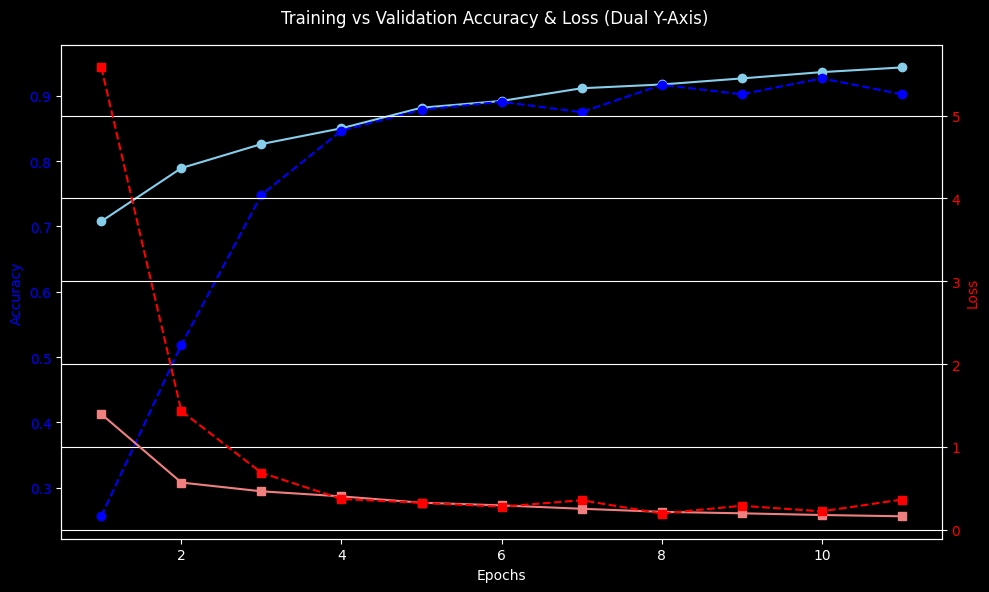

In [11]:
epochs = range(1, len(history.history['accuracy']) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy on left Y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='skyblue', marker='o')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second Y-axis for loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='red')
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='lightcoral', marker='s')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='s')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
fig.suptitle('Training vs Validation Accuracy & Loss (Dual Y-Axis)')
fig.tight_layout()
plt.grid(True)
plt.show()

## 🧪 Step 10: Evaluating the Model on Test Data

After training, we evaluate the model on the unseen **test dataset** using `model.evaluate()`.

- This function returns the **loss** and **accuracy** on the test set.
- It provides a final check on how well the model generalizes beyond the training data.

We then print the results:

- **Test Loss:** How well the model's predictions match the actual labels
- **Test Accuracy:** Proportion of correct predictions on the test set


In [12]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


41/41 [==============================] - 4s 99ms/step - loss: 14.6737 - accuracy: 0.2723
Test Loss: 14.6737
Test Accuracy: 0.2723


## 💾 Step 11: Saving the Trained Model

We save the trained CNN model using the `model.save()` method. This creates a `.h5` file that stores:

- The architecture of the model
- The learned weights
- The optimizer and loss configuration

### ✅ Why Save the Model?
Saving the model allows us to:
- Reuse it later without retraining
- Load it in external applications (like a Streamlit app)
- Share it with others or deploy it to production

In [13]:
model.save("model/brain_tumor_Classifier.h5")

c:\Users\kumar\OneDrive\Desktop\BrainTumorClassificationUsingCNN\tf310_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
